In [1]:
# Cell 1: Install Dependencies
!pip install torch torchvision torchaudio
!pip install cython
!pip install 'git+https://github.com/facebookresearch/fvcore'
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   -- ------------------------------------- 0.2/2.8 MB 6.3 MB/s eta 0:00:01
   -------- ------------------------------- 0.6/2.8 MB 7.6 MB/s eta 0:00:01
   -------------- ------------------------- 1.0/2.8 MB 7.9 MB/s eta 0:00:01
   --------------------- ------------------ 1.5/2.8 MB 8.7 MB/s eta 0:00:01
   ------------------------------- -------- 2.2/2.8 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------  2.8/2.8 MB 10.5 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 9.9 MB/s eta 0:00:00


ERROR: Invalid requirement: "'git+https://github.com/facebookresearch/fvcore'": Expected package name at the start of dependency specifier
    'git+https://github.com/facebookresearch/fvcore'
    ^


Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html


ERROR: Could not find a version that satisfies the requirement detectron2 (from versions: none)
ERROR: No matching distribution found for detectron2


In [2]:
!pip install git+https://github.com/facebookresearch/fvcore.git

  Cloning https://github.com/facebookresearch/fvcore.git to c:\users\dawoo\appdata\local\temp\pip-req-build-h5ycrw22
  Resolved https://github.com/facebookresearch/fvcore.git to commit 1d61132af7413155fedc197f72903d01c624bd01
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/42.2 kB ? eta -:--:--
     ---------------------------------------- 42.2/42.2 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=66103 sha256=962d49aa31b09c0a529e3758f7de3a1bced61d16e22b26beb850863d8c56845f
  Stored in directory: C:\Users\dawoo\AppData\Local\Temp\pip-ephem-wheel-cache-kdcp3sqe\wheels\f0\0c\4f\d358b3fbbc075812561fc600352afc7c17c6fb223304e39d97
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31543 sha256=2e6f675a03d286b191189093c5c80c85ca

  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git 'C:\Users\dawoo\AppData\Local\Temp\pip-req-build-h5ycrw22'


In [4]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu125/torch2.0/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu125/torch2.0/index.html


In [ ]:
python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
import os
import torch
from detectron2.engine import DefaultTrainer, HookBase
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.events import get_event_storage
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import random
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import detectron2.model_zoo as model_zoo

In [3]:
# Register the dataset
register_coco_instances("chair_train", {}, "D:/ARTIFICIAL INTELLIGENCE/SEMESTER 1/Computer Vision and Deep Learning/CV_PROJECT_LAZY_TRAIN/human-pose-estimation-opencv/Chair_occupancy/Training_chair_detection_FasterRCNN/dataset/annotations/instances_train2017.json", "D:/ARTIFICIAL INTELLIGENCE/SEMESTER 1/Computer Vision and Deep Learning/CV_PROJECT_LAZY_TRAIN/human-pose-estimation-opencv/Chair_occupancy/Training_chair_detection_FasterRCNN/dataset/images/train")
register_coco_instances("chair_val", {}, "D:/ARTIFICIAL INTELLIGENCE/SEMESTER 1/Computer Vision and Deep Learning/CV_PROJECT_LAZY_TRAIN/human-pose-estimation-opencv/Chair_occupancy/Training_chair_detection_FasterRCNN/dataset/annotations/instances_val2017.json", "D:/ARTIFICIAL INTELLIGENCE/SEMESTER 1/Computer Vision and Deep Learning/CV_PROJECT_LAZY_TRAIN/human-pose-estimation-opencv/Chair_occupancy/Training_chair_detection_FasterRCNN/dataset/images/val")

In [3]:
# Set up configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("chair_train",)
cfg.DATASETS.TEST = ("chair_val",)  # Validation dataset used for evaluation during training
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Use pre-trained weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 100
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class (chair)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Custom hook to save the model and print losses
class CustomHook(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg

    def after_step(self):
        # Save model checkpoint every 50 iterations
        iteration = self.trainer.iter
        if iteration % 1000 == 0 and iteration > 0:
            checkpoint_path = os.path.join(self.cfg.OUTPUT_DIR, f"model_checkpoint_iter_{iteration}")
            self.trainer.checkpointer.save(os.path.basename(checkpoint_path))
            print(f"Model checkpoint saved at iteration {iteration} to {checkpoint_path}.pth")

        # Print losses
        storage = get_event_storage()
        loss_cls = storage.history("loss_cls").latest()
        loss_box_reg = storage.history("loss_box_reg").latest()
        loss_rpn_cls = storage.history("loss_rpn_cls").latest()
        loss_rpn_loc = storage.history("loss_rpn_loc").latest()
        print(f"Iteration {iteration} - loss_cls: {loss_cls}, loss_box_reg: {loss_box_reg}, loss_rpn_cls: {loss_rpn_cls}, loss_rpn_loc: {loss_rpn_loc}")

# Initialize trainer
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

# Add custom hook
trainer.register_hooks([CustomHook(cfg)])

# Start training
trainer.train()

# After training, load the best model and run inference on test images
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_checkpoint_iter_5000.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the testing threshold for this model
predictor = DefaultPredictor(cfg)


[07/02 12:45:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[07/02 12:45:37 d2.engine.train_loop]: Starting training from iteration 0


c:\Users\dawoo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration 0 - loss_cls: 0.8676003217697144, loss_box_reg: 0.7070320844650269, loss_rpn_cls: 0.02003081515431404, loss_rpn_loc: 0.005067573394626379
Iteration 1 - loss_cls: 0.8571045398712158, loss_box_reg: 0.6255876421928406, loss_rpn_cls: 0.0682171881198883, loss_rpn_loc: 0.006860285997390747
Iteration 2 - loss_cls: 0.823550283908844, loss_box_reg: 0.5948636531829834, loss_rpn_cls: 0.1212795227766037, loss_rpn_loc: 0.022288646548986435
Iteration 3 - loss_cls: 0.7806364893913269, loss_box_reg: 0.6612274646759033, loss_rpn_cls: 0.02970316633582115, loss_rpn_loc: 0.06224547326564789
Iteration 4 - loss_cls: 0.8000110387802124, loss_box_reg: 0.7974729537963867, loss_rpn_cls: 0.04585523158311844, loss_rpn_loc: 0.015546068549156189
Iteration 5 - loss_cls: 0.7577360272407532, loss_box_reg: 0.959409773349762, loss_rpn_cls: 0.014508211985230446, loss_rpn_loc: 0.006382194347679615
Iteration 6 - loss_cls: 0.9033633470535278, loss_box_reg: 0.6162523031234741, loss_rpn_cls: 0.027432987466454506, lo

AssertionError: Checkpoint ./output\model_checkpoint_iter_5000.pth not found!

In [17]:
# Path to test images
test_image_dir = "D:/ARTIFICIAL INTELLIGENCE/SEMESTER 1/Computer Vision and Deep Learning/CV_PROJECT_LAZY_TRAIN/human-pose-estimation-opencv/Chair_occupancy/Training_chair_detection/dataset/images/test"

# Visualize predictions on a few test images
test_images = os.listdir(test_image_dir)
for img_name in random.sample(test_images, 3):  # Change the number to visualize more images
    img_path = os.path.join(test_image_dir, img_name)
    img = cv2.imread(img_path)
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=detectron2.data.MetadataCatalog.get("chair_val"), 
                   scale=0.8, 
                   instance_mode=detectron2.utils.visualizer.ColorMode.IMAGE_BW)  # Remove the colors of unsegmented pixels
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(14, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

NameError: name 'detectron2' is not defined

In [18]:
# Evaluate on the validation set and generate classification report and confusion matrix
evaluator = COCOEvaluator("chair_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "chair_val")
evaluation_results = inference_on_dataset(predictor.model, val_loader, evaluator)

# Extract ground truth and predictions
gt_classes = []
pred_classes = []

for outputs in evaluation_results:
    instances = outputs["instances"].to("cpu")
    gt_classes.extend(instances.gt_classes.tolist())
    pred_classes.extend(instances.pred_classes.tolist())

# Generate classification report
print("Classification Report:")
print(classification_report(gt_classes, pred_classes, target_names=["chair"]))

# Generate confusion matrix
cm = confusion_matrix(gt_classes, pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["chair"], yticklabels=["chair"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

WARNING [06/30 14:56:43 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [06/30 14:56:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/30 14:56:43 d2.data.datasets.coco]: Loaded 580 images in COCO format from D:/ARTIFICIAL INTELLIGENCE/SEMESTER 1/Computer Vision and Deep Learning/CV_PROJECT_LAZY_TRAIN/human-pose-estimation-opencv/Chair_occupancy/Training_chair_detection/dataset/annotations/instances_val2017.json
[06/30 14:56:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/30 14:56:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/30 14:56:43 d2.data.common]: Serializing 580 elements to byte tensors and concatenating them all ...
[06/3

TypeError: string indices must be integers, not 'str'

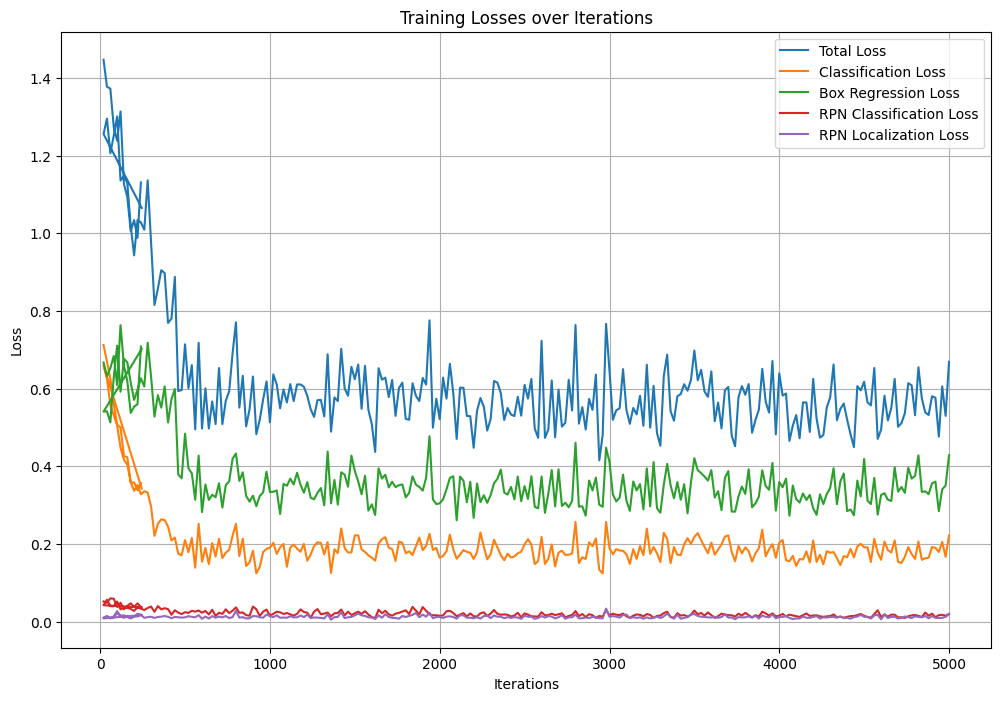

In [10]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# Load the metrics data
metrics_path = "D:/ARTIFICIAL INTELLIGENCE/SEMESTER 1/Computer Vision and Deep Learning/CV_PROJECT_LAZY_TRAIN/human-pose-estimation-opencv/Chair_occupancy/Training_chair_detection/output/metrics.json"

with open(metrics_path, 'r') as f:
    metrics = [json.loads(line) for line in f]

# Convert metrics to a pandas DataFrame
df_metrics = pd.DataFrame(metrics)

# Extract iteration and loss values
iterations = df_metrics['iteration']
total_loss = df_metrics['total_loss']
loss_cls = df_metrics['loss_cls']
loss_box_reg = df_metrics['loss_box_reg']
loss_rpn_cls = df_metrics['loss_rpn_cls']
loss_rpn_loc = df_metrics['loss_rpn_loc']

# Plot the losses
plt.figure(figsize=(12, 8))
plt.plot(iterations, total_loss, label='Total Loss')
plt.plot(iterations, loss_cls, label='Classification Loss')
plt.plot(iterations, loss_box_reg, label='Box Regression Loss')
plt.plot(iterations, loss_rpn_cls, label='RPN Classification Loss')
plt.plot(iterations, loss_rpn_loc, label='RPN Localization Loss')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Losses over Iterations')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
import os
import torch
from detectron2.engine import DefaultTrainer, HookBase
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.events import EventStorage, get_event_storage
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import matplotlib.pyplot as plt
import numpy as np
import detectron2.model_zoo as model_zoo

# Register the dataset
#register_coco_instances("chair_train", {}, "D:/ARTIFICIAL INTELLIGENCE/SEMESTER 1/Computer Vision and Deep Learning/CV_PROJECT_LAZY_TRAIN/human-pose-estimation-opencv/Chair_occupancy/Training_chair_detection/dataset/annotations/instances_train2017.json", "D:/ARTIFICIAL INTELLIGENCE/SEMESTER 1/Computer Vision and Deep Learning/CV_PROJECT_LAZY_TRAIN/human-pose-estimation-opencv/Chair_occupancy/Training_chair_detection/dataset/images/train")
#register_coco_instances("chair_val", {}, "D:/ARTIFICIAL INTELLIGENCE/SEMESTER 1/Computer Vision and Deep Learning/CV_PROJECT_LAZY_TRAIN/human-pose-estimation-opencv/Chair_occupancy/Training_chair_detection/dataset/annotations/instances_val2017.json", "D:/ARTIFICIAL INTELLIGENCE/SEMESTER 1/Computer Vision and Deep Learning/CV_PROJECT_LAZY_TRAIN/human-pose-estimation-opencv/Chair_occupancy/Training_chair_detection/dataset/images/val")

# Set up configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("chair_train",)
cfg.DATASETS.TEST = ("chair_val",)  # Validation dataset used for evaluation during training
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Use pre-trained weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class (chair)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Custom hook to save the model and log losses
class CustomHook(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.iterations = []
        self.loss_cls = []
        self.loss_box_reg = []
        self.loss_rpn_cls = []
        self.loss_rpn_loc = []
        self.total_loss = []

    def after_step(self):
        iteration = self.trainer.iter
        storage = get_event_storage()
        
        # Save model checkpoint every 5000 iterations
        if iteration % 5000 == 0 and iteration > 0:
            checkpoint_path = os.path.join(self.cfg.OUTPUT_DIR, f"model_checkpoint_iter_{iteration}.pth")
            self.trainer.checkpointer.save(checkpoint_path)
            print(f"Model checkpoint saved at iteration {iteration} to {checkpoint_path}")
        
        # Log losses
        self.iterations.append(iteration)
        self.loss_cls.append(storage.history("loss_cls").latest())
        self.loss_box_reg.append(storage.history("loss_box_reg").latest())
        self.loss_rpn_cls.append(storage.history("loss_rpn_cls").latest())
        self.loss_rpn_loc.append(storage.history("loss_rpn_loc").latest())
        self.total_loss.append(storage.history("total_loss").latest())

# Initialize trainer
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

# Add custom hook
custom_hook = CustomHook(cfg)
trainer.register_hooks([custom_hook])

# Start training
trainer.train()

# Plot losses
plt.figure(figsize=(12, 8))
plt.plot(custom_hook.iterations, custom_hook.total_loss, label='Total Loss')
plt.plot(custom_hook.iterations, custom_hook.loss_cls, label='Classification Loss')
plt.plot(custom_hook.iterations, custom_hook.loss_box_reg, label='Box Regression Loss')
plt.plot(custom_hook.iterations, custom_hook.loss_rpn_cls, label='RPN Classification Loss')
plt.plot(custom_hook.iterations, custom_hook.loss_rpn_loc, label='RPN Localization Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Losses over Iterations')
plt.legend()
plt.grid(True)
plt.show()

# After training, load the final model and run inference on test images
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the testing threshold for this model
predictor = DefaultPredictor(cfg)

# Evaluate the model on the validation set to get precision, recall, and mAP
evaluator = COCOEvaluator("chair_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "chair_val")
evaluation_results = inference_on_dataset(predictor.model, val_loader, evaluator)
print("Evaluation Results:", evaluation_results)



[07/02 17:53:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[07/02 17:53:10 d2.engine.train_loop]: Starting training from iteration 0
[07/02 17:53:23 d2.utils.events]:  eta: 1:23:06  iter: 19  total_loss: 1.358  loss_cls: 0.6555  loss_box_reg: 0.6172  loss_rpn_cls: 0.05052  loss_rpn_loc: 0.01919    time: 0.4879  last_time: 0.4409  data_time: 0.1774  last_data_time: 0.0012   lr: 4.9953e-06  max_mem: 4296M
[07/02 17:53:33 d2.utils.events]:  eta: 1:19:14  iter: 39  total_loss: 1.362  loss_cls: 0.6377  loss_box_reg: 0.6531  loss_rpn_cls: 0.0401  loss_rpn_loc: 0.01268    time: 0.4864  last_time: 0.4647  data_time: 0.0014  last_data_time: 0.0007   lr: 9.9902e-06  max_mem: 4297M
[07/02 17:53:42 d2.utils.events]:  eta: 1:18:55  iter: 59  total_loss: 1.321  loss_cls: 0.6118  loss_box_reg: 0.6111  loss_rpn_cls: 0.04785  loss_rpn_loc: 0.02175    time: 0.4807  last_time: 0.4847  data_time: 0.0013  last_data_time: 0.0009   lr: 1.4985e-05  max_mem: 4297M
[07/02 17:53:52 d2.utils.events]:  eta: 1:18:46  iter: 79  total_loss: 1.22  loss_cls: 0.5487  loss_box_r

AssertionError: ./output\model_checkpoint_iter_5000.pth.pth

In [6]:
# After training, load the final model and run inference on test images
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "D:/ARTIFICIAL INTELLIGENCE/SEMESTER 1/Computer Vision and Deep Learning/CV_PROJECT_LAZY_TRAIN/human-pose-estimation-opencv/Chair_occupancy/Training_chair_detection_FasterRCNN/output/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the testing threshold for this model
predictor = DefaultPredictor(cfg)

# Evaluate the model on the validation set to get precision, recall, and mAP
evaluator = COCOEvaluator("chair_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "chair_val")
evaluation_results = inference_on_dataset(predictor.model, val_loader, evaluator)
print("Evaluation Results:", evaluation_results)



[07/02 18:52:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from D:/ARTIFICIAL INTELLIGENCE/SEMESTER 1/Computer Vision and Deep Learning/CV_PROJECT_LAZY_TRAIN/human-pose-estimation-opencv/Chair_occupancy/Training_chair_detection_FasterRCNN/output/model_final.pth ...
WARNING [07/02 18:52:06 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [07/02 18:52:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/02 18:52:06 d2.data.datasets.coco]: Loaded 580 images in COCO format from D:/ARTIFICIAL INTELLIGENCE/SEMESTER 1/Computer Vision and Deep Learning/CV_PROJECT_LAZY_TRAIN/human-pose-estimation-opencv/Chair_occupancy/Training_chair_detection_FasterRCNN/dataset/annotations/instances_val2017.json
[07/02 18:52:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortes